In [1]:
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.cluster.ga import genetic_algorithm, ga_observer, ga_visualizer
from pyclustering.cluster.kmedoids import kmedoids
import string 
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2
from geopy import distance
import pandas as pd
from pyclustering.cluster import cluster_visualizer
sns.set()

In [2]:
url = "C:\\Users\\ACER\\Downloads\\dataGPS.xlsx"
df = pd.read_excel(url)

In [3]:
df.head()

,id,latitude,longitude,address,province,district,ward
0,214443,10.643571,106.732056,"Số 560 Đường Nguyễn Văn Tạo - Ấp 1, Xã Long Th...",Hồ Chí Minh,Huyện Nhà Bè,Xã Long Thới
1,217689,10.658587,106.607364,"D16/41 Đoàn Nguyễn Tuân Ấp 4, Xã Hưng Long, Hu...",Hồ Chí Minh,Huyện Bình Chánh,Xã Hưng Long
2,176037,10.665509,106.570818,"A23/8 Quốc Lộ 50, Xã Bình Hưng, Huyện Bình Chá...",Hồ Chí Minh,Huyện Bình Chánh,Xã Bình Hưng
3,219913,10.666189,106.571738,"D1/1 Quốc lộ 1A Ấp 4, Xã Bình Chánh, Huyện Bìn...",Hồ Chí Minh,Huyện Bình Chánh,Xã Bình Chánh
4,173829,10.667867,106.621979,"D1/1 Quốc lộ 1A Ấp 4, Xã Bình Chánh, Huyện Bìn...",Hồ Chí Minh,Huyện Bình Chánh,Xã Bình Chánh


# Test data sample GPS

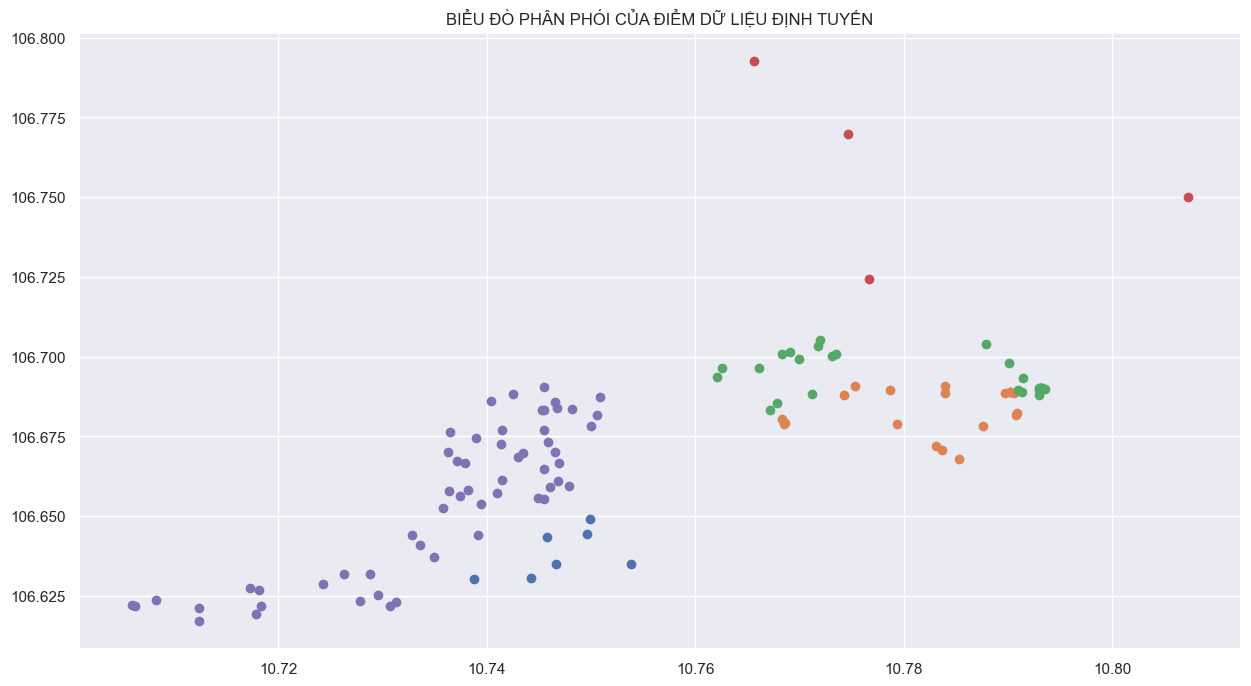

In [4]:
fig = plt.figure(figsize=(15, 8))

plt.title("BIỂU ĐỒ PHÂN PHỐI CỦA ĐIỂM DỮ LIỆU ĐỊNH TUYẾN")
plt.scatter(df.loc[df["district"] == "Quận 6", ["latitude", "longitude"]]["latitude"], 
            df.loc[df["district"] == "Quận 6", ["latitude", "longitude"]]["longitude"])
plt.scatter(df.loc[df["district"] == "Quận 3", ["latitude", "longitude"]]["latitude"], 
            df.loc[df["district"] == "Quận 3", ["latitude", "longitude"]]["longitude"])
plt.scatter(df.loc[df["district"] == "Quận 1", ["latitude", "longitude"]]["latitude"], 
            df.loc[df["district"] == "Quận 1", ["latitude", "longitude"]]["longitude"])
plt.scatter(df.loc[df["district"] == "Quận 2", ["latitude", "longitude"]]["latitude"], 
            df.loc[df["district"] == "Quận 2", ["latitude", "longitude"]]["longitude"])
plt.scatter(df.loc[df["district"] == "Quận 8", ["latitude", "longitude"]]["latitude"], 
            df.loc[df["district"] == "Quận 8", ["latitude", "longitude"]]["longitude"])
plt.show()

In [5]:
def create_data(number_district):
    data = pd.DataFrame()
    for i in range(number_district):
        name_district = input("Enter district:")
        loc_district = df.loc[df["district"] == name_district, ["latitude", "longitude"]]
        
        data = pd.concat([data, loc_district], axis=0)
    return data.to_numpy()

In [6]:
data_test = create_data(6)

Enter district:Quận 6
Enter district:Quận 3
Enter district:Quận 2
Enter district:Quận 1
Enter district:Quận 8
Enter district:Bình Thạnh


# Clustering

In [7]:
class clustering:
    def __init__(self, data, num_cluster):
        """
            Input: 
                data: Bộ dữ liệu cần phân loại
                num_cluster: Số cụm sẽ phân loại
        """
        self.data = data
        self.num_cluster = num_cluster
        
    def set_up(self, data, clusters):
        loc_set = []
        for i in range(len(clusters)):
            loc_set.append(data[clusters[i], :])
        return loc_set
    
    def Cluster_type(self, name_cluster):
        
        if name_cluster == "kmeans":
            initial_centers = kmeans_plusplus_initializer(self.data, self.num_cluster).initialize()
            # Create instance of K-Means algorithm with prepared centers.
            kmeans_instance = kmeans(self.data, initial_centers)
            # Run cluster analysis and obtain results.
            kmeans_instance.process()
            clusters = kmeans_instance.get_clusters()

            loc_set = self.set_up(self.data, clusters)
            return loc_set

        elif name_cluster == "Kmedoids":
            # khởi tọa các điểm trung tâm tại các cụm
            initial_medoids = kmeans_plusplus_initializer(self.data, self.num_cluster).initialize(return_index=True)

            kmedoids_instance  = kmedoids(self.data, initial_medoids)

            # Run cluster analysis and obtain results.
            kmedoids_instance.process()
            clusters_k = kmedoids_instance.get_clusters()
            loc_set = self.set_up(self.data, clusters_k)
            
            return loc_set
        elif name_cluster == "genetic":
            observer_instance = ga_observer(True, True, True)
            # Create genetic algorithm for clustering
            ga_instance = genetic_algorithm(data=self.data,
                                            count_clusters=self.num_cluster,
                                            chromosome_count=10,
                                            population_count=3,
                                            count_mutation_gens=1)
            ga_instance.process()
            clusters_g = ga_instance.get_clusters()
            loc_set = self.set_up(self.data, clusters_g)
            return loc_set

In [8]:
def distances(list_point, depot):
    
    depot = depot
    list_point = np.append(list_point, depot, axis=0)
    mat=[[0 for _ in range(len(list_point))]for _ in range(len(list_point))]
    for i in range(0,len(list_point)): 
        for j in range(i+1,len(list_point)): 
            
            mat[i][j]= calculate_distance(list_point[i],list_point[j])
            mat[j][i]=mat[i][j]
    return mat

def calculate_distance(point1, point2):
    return round((((point1[0] - point2[0])**2 + (point1[1] - point2[1])**2)**0.5)*1000, 2)

# create model
def create_model_data(data_point, depot):
    data = {}
    
#     distances(data_point)
    
    data["distance_matrix"] = distances(data_point, depot)
    data["number_vehicles"] = 1
    data["depot"] = len(data["distance_matrix"])-1
    return data

def print_solution(data, manager, routing, solution):
    
    
    max_route_distance = 0
    route = []
    for vehicle_id in range(data["number_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"route for vehicle {vehicle_id}:\n"
        route_distance = 0
        while not routing.IsEnd(index):
            route.append(manager.IndexToNode(index))
            plan_output += f" {manager.IndexToNode(index)} ->"
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, vehicle_id)
        plan_output += f" {manager.IndexToNode(index)}\n"
        plan_output += f" Distance of the route: {route_distance}km\n"
        print(plan_output)
        max_route_distance = max(route_distance, max_route_distance)
    print(f"Maximum of the route distances: {max_route_distance}")
    return [route, max_route_distance]

def main(data_point, data, depot):
    data = create_model_data(data_point, depot)
    
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]), 
                                           data["number_vehicles"],
                                           data["depot"])
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    
    dimension_name = "Distance"

    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.solution_limit = 200

    
    search_parameters.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.TABU_SEARCH
    search_parameters.time_limit.seconds = 30
    
    search_parameters.log_search = True
    solution = routing.SolveWithParameters(search_parameters)
    if solution:
        return print_solution(data, manager, routing, solution)
    else:
        print("No solution found !")
        
def show_result(data, loc_set, depot):
    fig = plt.figure(figsize=(15, 8))
    cols = ['red', 'blue', "green", "orange", "#800000", "#033E3E"]
    total_distance = 0
    for i, col in zip(range(len(loc_set)), cols):
        print("====================== cluster {} ================".format(i))
    #     A= [data.index(point) for point in loc_set[i]]
        result_routing = main(loc_set[i], data, depot)
        total_distance += result_routing[1]
        x_coord = []
        y_coord = []
        for coor in result_routing[0][1:]:
            x_coord.append(loc_set[i][coor][0])
            y_coord.append(loc_set[i][coor][1])
            # Vẽ tuyến đường đi bằng cách nối các điểm

            plt.scatter(x_coord, y_coord, marker='o')
            route = [data]
        routing = [loc_set[i][point] for point in result_routing[0][1:]]
        route_main = np.append(depot, routing, axis=0)
        route_main = np.append(route_main, depot, axis=0)
        for t in range(len(route_main)-1):
            plt.annotate("", xy=route_main[t+1], xytext = route_main[t], arrowprops=dict(arrowstyle="->", color=col))
    plt.scatter(depot[0][0], depot[0][1], marker='o', c="red")
    plt.show()
    return total_distance

In [12]:
depot = np.array([[10.755263, 106.7175419]]) 

# I.Thử nghiệm bộ dữ liệu GPS

## Kmeans

In [9]:
cl = clustering(data_test, 6)

In [10]:
loc_set_kmeans = cl.Cluster_type("kmeans")

====================== cluster 0 ================
route for vehicle 0:
 24 -> 16 -> 8 -> 10 -> 15 -> 14 -> 11 -> 7 -> 9 -> 13 -> 6 -> 5 -> 12 -> 0 -> 1 -> 4 -> 2 -> 3 -> 19 -> 17 -> 20 -> 23 -> 21 -> 18 -> 22 -> 24
 Distance of the route: 193km

Maximum of the route distances: 193
====================== cluster 1 ================
route for vehicle 0:
 1 -> 0 -> 1
 Distance of the route: 122km

Maximum of the route distances: 122
====================== cluster 2 ================
route for vehicle 0:
 47 -> 30 -> 29 -> 31 -> 32 -> 27 -> 25 -> 26 -> 22 -> 21 -> 20 -> 24 -> 23 -> 0 -> 1 -> 2 -> 28 -> 3 -> 4 -> 5 -> 9 -> 10 -> 6 -> 7 -> 8 -> 11 -> 12 -> 17 -> 18 -> 39 -> 40 -> 44 -> 45 -> 43 -> 42 -> 41 -> 38 -> 36 -> 16 -> 14 -> 15 -> 13 -> 35 -> 37 -> 46 -> 34 -> 33 -> 19 -> 47
 Distance of the route: 201km

Maximum of the route distances: 201
====================== cluster 3 ================
route for vehicle 0:
 20 -> 18 -> 19 -> 14 -> 12 -> 11 -> 9 -> 7 -> 5 -> 4 -> 2 -> 3 -> 6 -> 8 ->

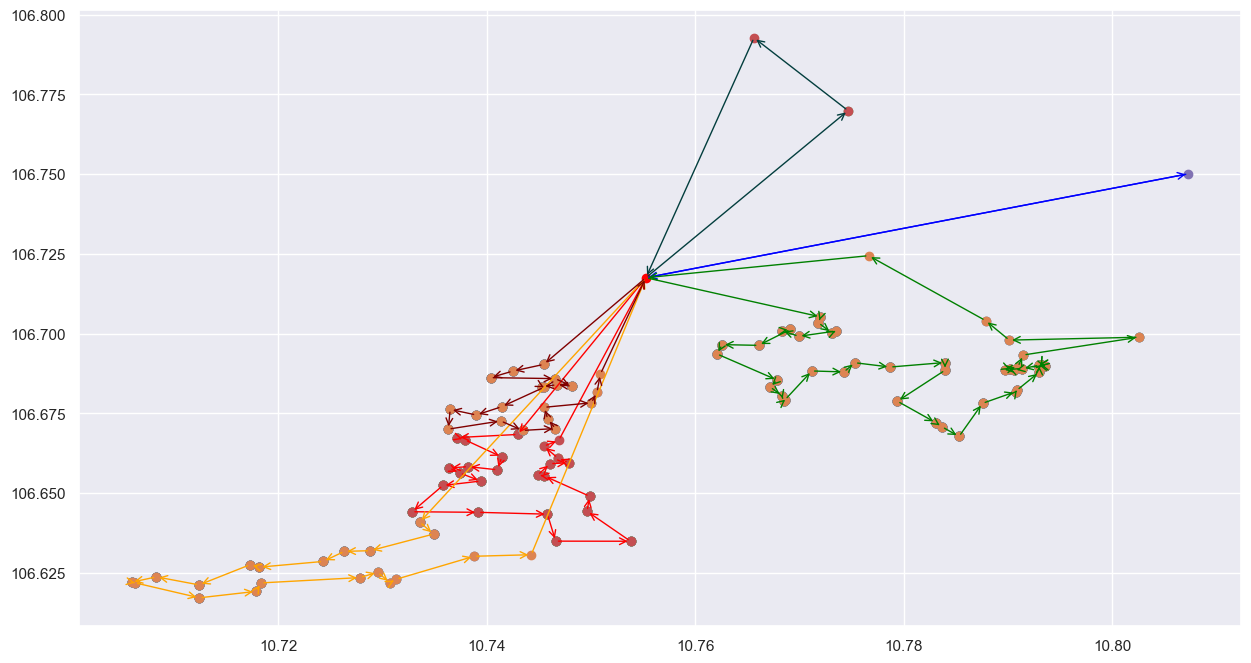

In [13]:
resutl_distance_kmeans = show_result(data_test, loc_set_kmeans, depot)

In [14]:
print("Tổng khoảng cách đi được: {} km".format(resutl_distance_kmeans))

Tổng khoảng cách đi được: 1038 km


## Kmedoids

====================== cluster 0 ================
route for vehicle 0:
 20 -> 15 -> 18 -> 19 -> 17 -> 14 -> 16 -> 3 -> 2 -> 4 -> 1 -> 0 -> 10 -> 5 -> 6 -> 11 -> 8 -> 7 -> 9 -> 12 -> 13 -> 20
 Distance of the route: 188km

Maximum of the route distances: 188
====================== cluster 1 ================
route for vehicle 0:
 3 -> 0 -> 1 -> 2 -> 3
 Distance of the route: 198km

Maximum of the route distances: 198
====================== cluster 2 ================
route for vehicle 0:
 28 -> 0 -> 4 -> 5 -> 1 -> 2 -> 3 -> 6 -> 7 -> 12 -> 13 -> 20 -> 10 -> 9 -> 8 -> 11 -> 16 -> 17 -> 19 -> 21 -> 22 -> 23 -> 24 -> 26 -> 25 -> 18 -> 27 -> 15 -> 14 -> 28
 Distance of the route: 156km

Maximum of the route distances: 156
====================== cluster 3 ================
route for vehicle 0:
 24 -> 12 -> 8 -> 5 -> 16 -> 20 -> 18 -> 11 -> 13 -> 7 -> 4 -> 1 -> 0 -> 2 -> 3 -> 6 -> 10 -> 9 -> 19 -> 17 -> 15 -> 14 -> 21 -> 22 -> 23 -> 24
 Distance of the route: 130km

Maximum of the route distance

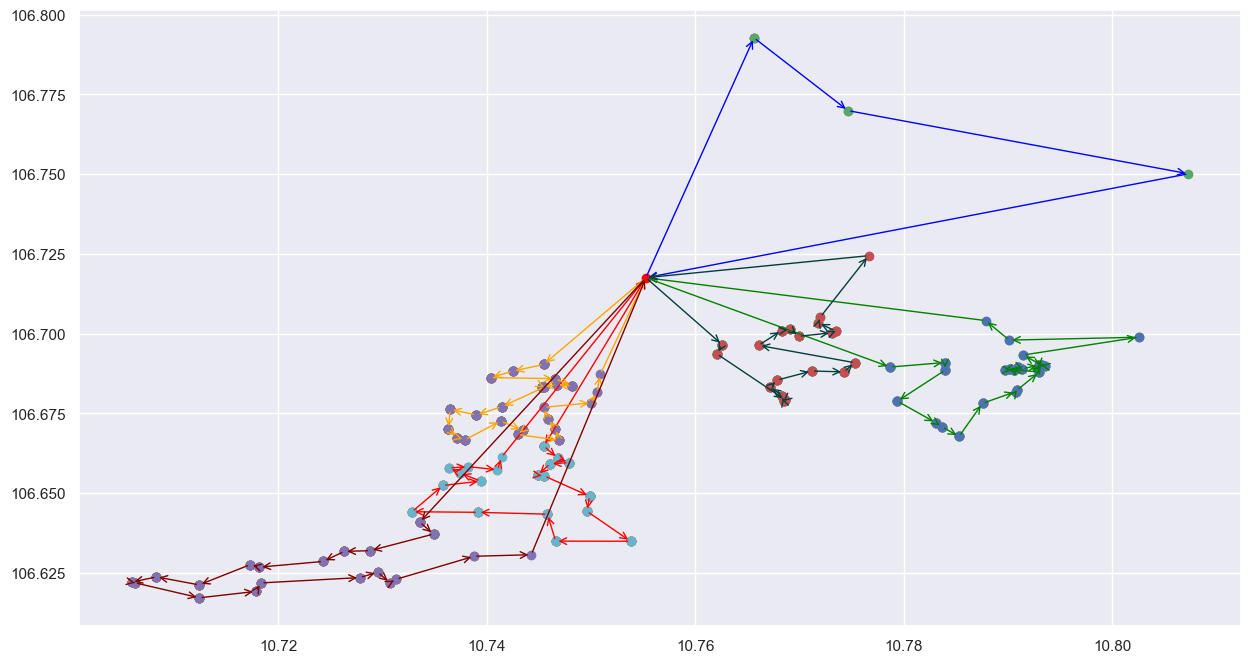

In [15]:
loc_set_kmedoids =  cl.Cluster_type("Kmedoids")
resutl_distance_kmedoids = show_result(data_test, loc_set_kmedoids, depot)

In [16]:
print("Tổng khoảng cách đi được: {} km".format(resutl_distance_kmedoids))

Tổng khoảng cách đi được: 1038 km


## Genetic

====================== cluster 0 ================
route for vehicle 0:
 16 -> 2 -> 3 -> 4 -> 1 -> 0 -> 8 -> 7 -> 5 -> 6 -> 9 -> 11 -> 10 -> 12 -> 15 -> 14 -> 13 -> 16
 Distance of the route: 275km

Maximum of the route distances: 275
====================== cluster 1 ================
route for vehicle 0:
 12 -> 10 -> 11 -> 8 -> 9 -> 6 -> 7 -> 0 -> 3 -> 1 -> 5 -> 4 -> 2 -> 12
 Distance of the route: 348km

Maximum of the route distances: 348
====================== cluster 2 ================
route for vehicle 0:
 27 -> 7 -> 25 -> 24 -> 22 -> 20 -> 17 -> 13 -> 14 -> 18 -> 12 -> 16 -> 9 -> 11 -> 10 -> 15 -> 0 -> 21 -> 19 -> 23 -> 1 -> 2 -> 5 -> 3 -> 4 -> 8 -> 26 -> 6 -> 27
 Distance of the route: 462km

Maximum of the route distances: 462
====================== cluster 3 ================
route for vehicle 0:
 16 -> 13 -> 12 -> 11 -> 10 -> 0 -> 14 -> 15 -> 6 -> 1 -> 3 -> 8 -> 9 -> 7 -> 2 -> 5 -> 4 -> 16
 Distance of the route: 292km

Maximum of the route distances: 292
======================

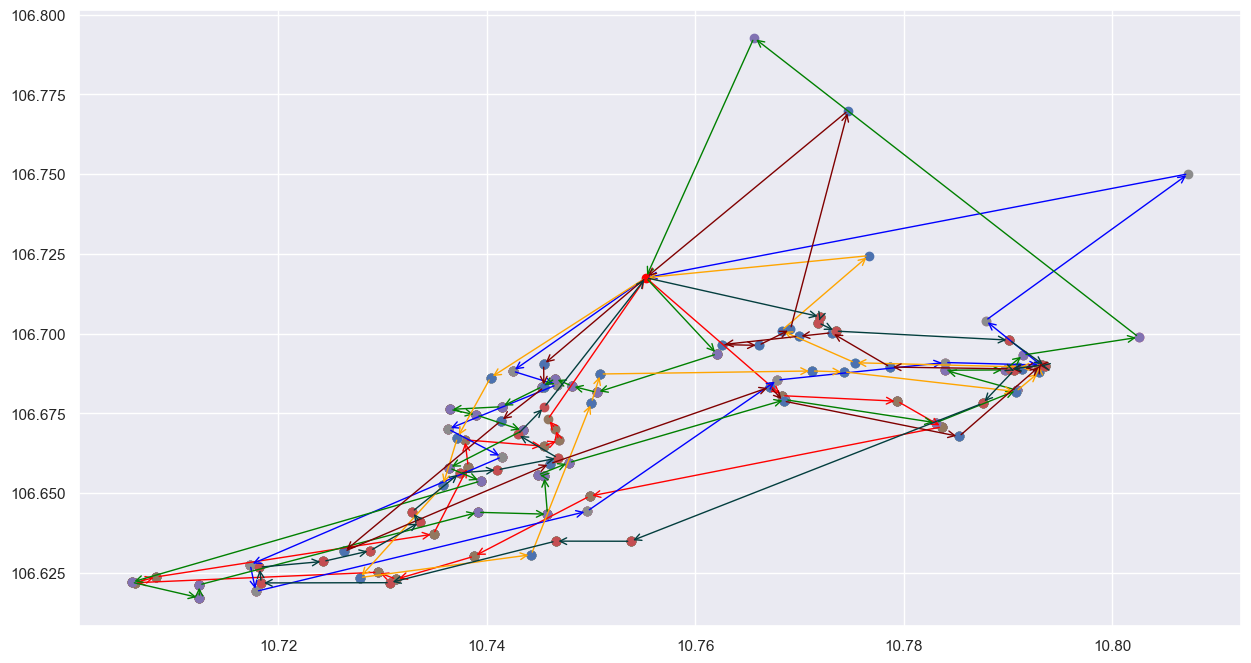

In [17]:
loc_set_genetic =  cl.Cluster_type("genetic")
resutl_distance_genetic = show_result(data_test, loc_set_genetic, depot)

In [18]:
print("Tổng khoảng cách đi được: {} km".format(resutl_distance_genetic))

Tổng khoảng cách đi được: 2004 km


# II.Thử nghiệm dataMau

In [19]:
data_t = pd.read_excel("C:\\Users\\ACER\\Downloads\\dataMau.xlsx")

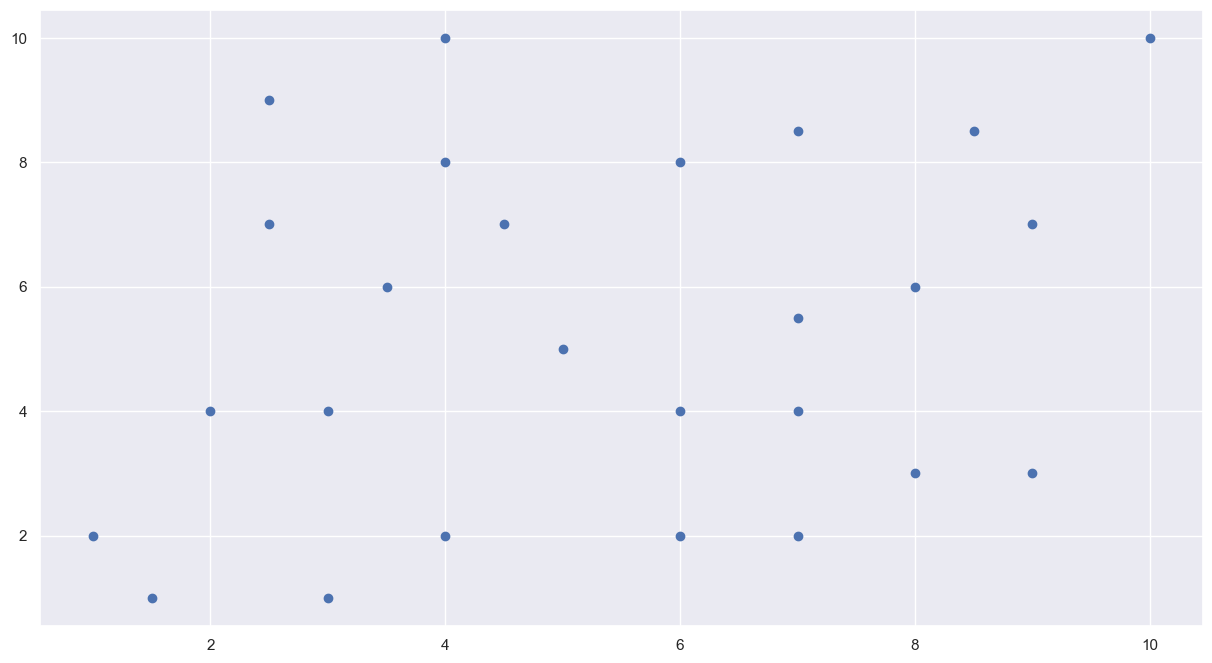

In [20]:
fig = plt.figure(figsize=(15, 8))

plt.scatter(data_t["latitude"], data_t["longitude"])
plt.show()

In [21]:
data_test_sample_mau = data_t[["latitude", "longitude"]].to_numpy()[1:]
data_depot_test_sample_mau = np.array([data_t[["latitude", "longitude"]].to_numpy()[0]])

## Kmean

In [22]:
cl_test = clustering(data_test_sample_mau, 4)
loc_set_test_kmean = cl_test.Cluster_type("kmeans")

====================== cluster 0 ================
route for vehicle 0:
 10 -> 0 -> 4 -> 3 -> 2 -> 1 -> 5 -> 7 -> 8 -> 9 -> 6 -> 10
 Distance of the route: 22564km

Maximum of the route distances: 22564
====================== cluster 1 ================
route for vehicle 0:
 5 -> 4 -> 1 -> 2 -> 3 -> 0 -> 5
 Distance of the route: 14194km

Maximum of the route distances: 14194
====================== cluster 2 ================
route for vehicle 0:
 4 -> 0 -> 1 -> 2 -> 3 -> 4
 Distance of the route: 9493km

Maximum of the route distances: 9493
====================== cluster 3 ================
route for vehicle 0:
 6 -> 0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 6
 Distance of the route: 14417km

Maximum of the route distances: 14417


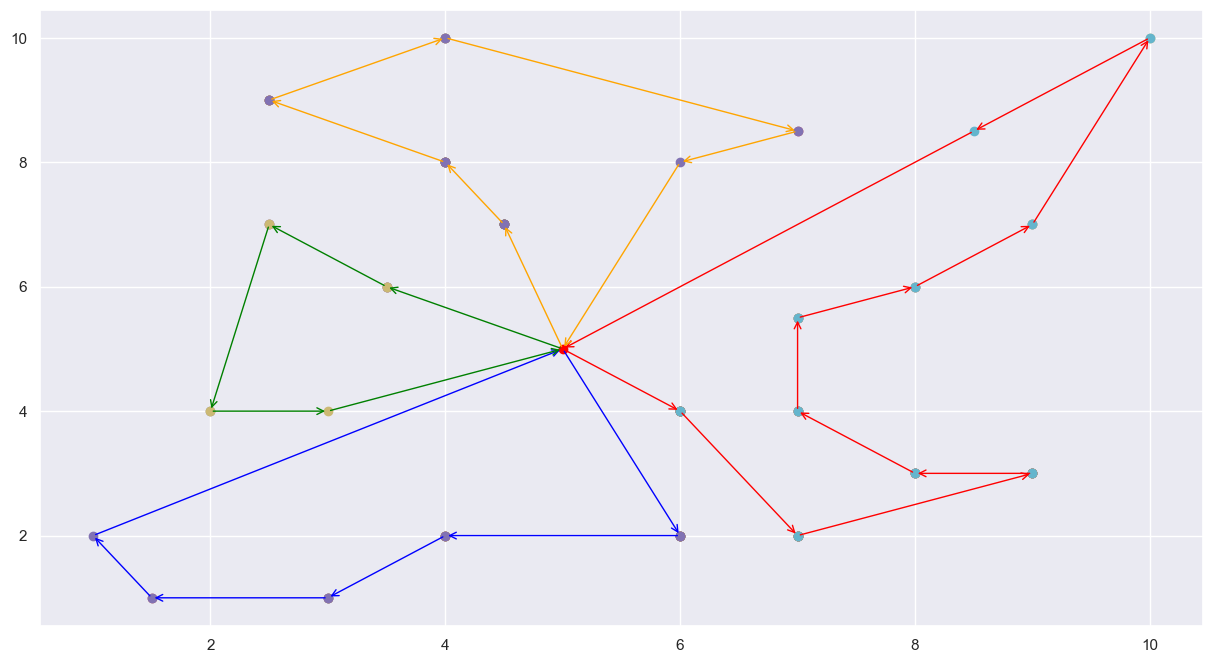

In [23]:
distance_kmean_test_sample = show_result(data_test_sample_mau, loc_set_test_kmean, data_depot_test_sample_mau)

In [24]:
print("Tổng khoảng cách đi được: {} km".format(distance_kmean_test_sample))

Tổng khoảng cách đi được: 60668 km


## Genetic

====================== cluster 0 ================
route for vehicle 0:
 10 -> 5 -> 6 -> 7 -> 8 -> 3 -> 4 -> 2 -> 0 -> 1 -> 9 -> 10
 Distance of the route: 26146km

Maximum of the route distances: 26146
====================== cluster 1 ================
route for vehicle 0:
 3 -> 0 -> 1 -> 2 -> 3
 Distance of the route: 16032km

Maximum of the route distances: 16032
====================== cluster 2 ================
route for vehicle 0:
 5 -> 4 -> 3 -> 2 -> 1 -> 0 -> 5
 Distance of the route: 19567km

Maximum of the route distances: 19567
====================== cluster 3 ================
route for vehicle 0:
 7 -> 4 -> 1 -> 2 -> 3 -> 6 -> 5 -> 0 -> 7
 Distance of the route: 21781km

Maximum of the route distances: 21781


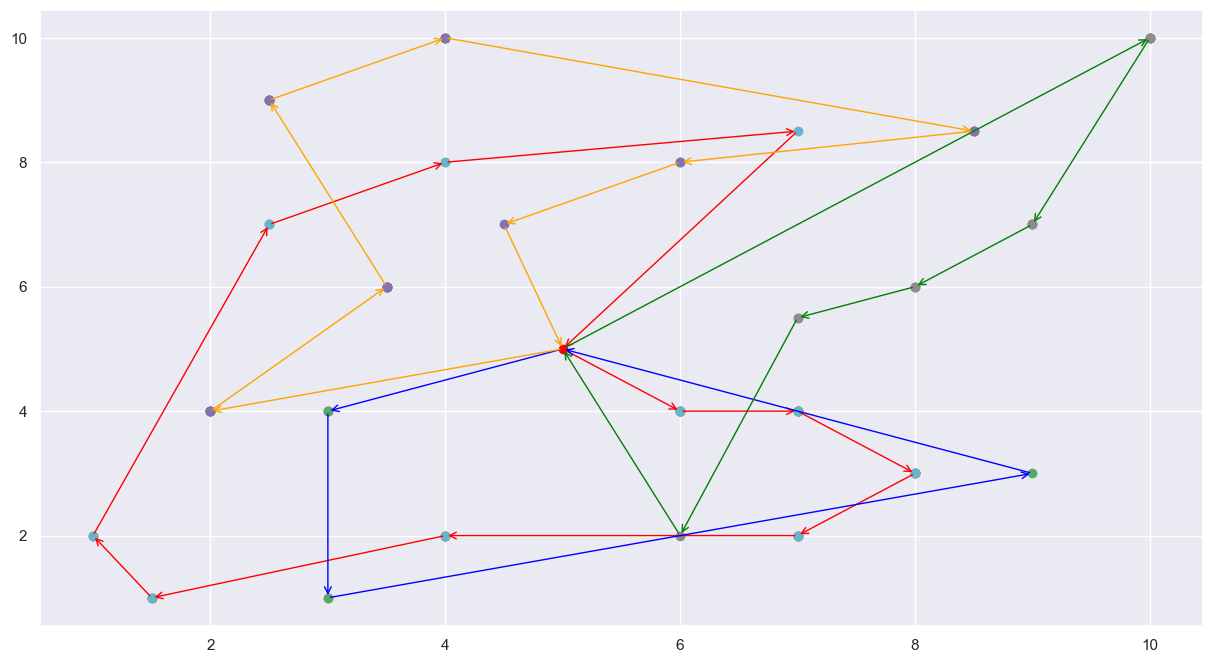

In [25]:
loc_set_test_genetic = cl_test.Cluster_type("genetic")
distance_genetic_test_sample = show_result(data_test_sample_mau, loc_set_test_genetic, data_depot_test_sample_mau)

In [26]:
print("Tổng khoảng cách đi được: {} km".format(distance_genetic_test_sample))

Tổng khoảng cách đi được: 83526 km


# III. Thử nghiệm dataMau (1) 

In [27]:
data_sample_1 = pd.read_excel("C:\\Users\\ACER\\Downloads\\dataMau (1).xlsx")

In [28]:
data_sample_1.head()

,Unnamed: 0,latitude,longitude,Unnamed: 3
0,NaN,10.808764,106.692029,1
1,NaN,10.808174,106.689840,1
2,NaN,10.805982,106.688552,1
3,NaN,10.804759,106.690097,1
4,NaN,10.806319,106.693917,1


In [29]:
data_test_sample_1 = data_sample_1[["latitude", "longitude"]].to_numpy()[1:]
label = data_sample_1["Unnamed: 3"]
data_depot_test_sample_1 = np.array([data_sample_1[["latitude", "longitude"]].to_numpy()[0]])

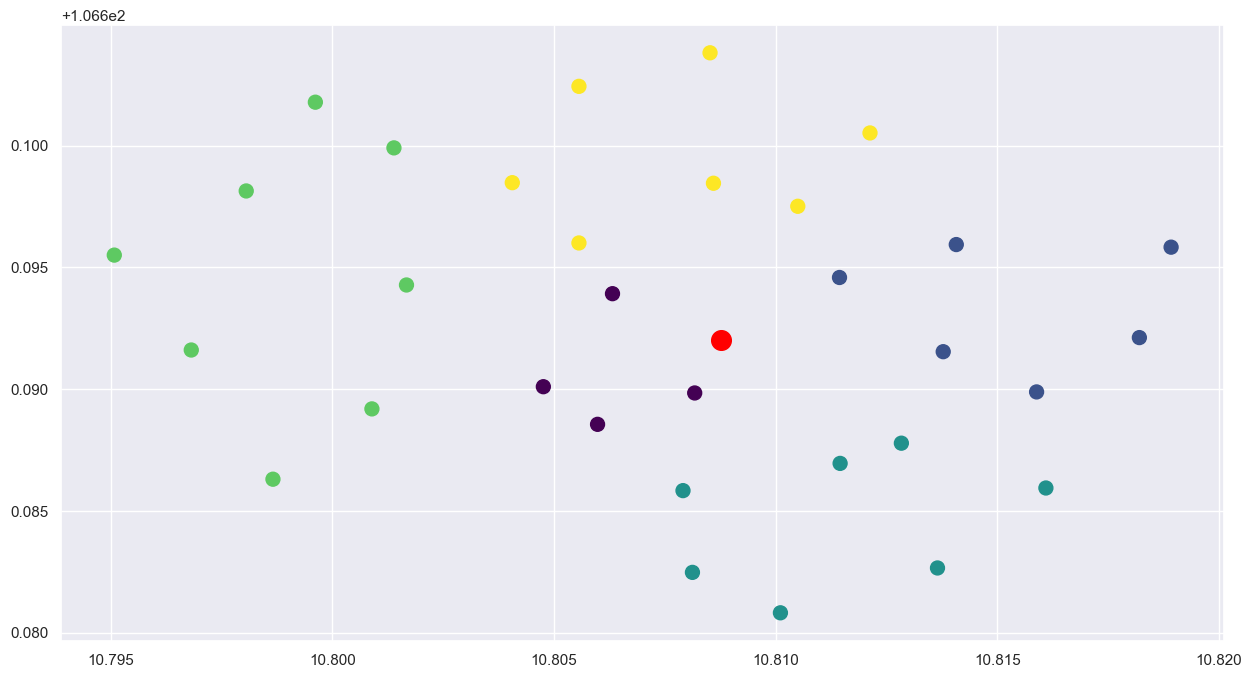

In [30]:
fig = plt.figure(figsize=(15, 8))

plt.scatter(data_test_sample_1[:, 0], data_test_sample_1[:, 1], c=label[1:], cmap='viridis', s=100)
plt.scatter(data_depot_test_sample_1[:, 0], data_depot_test_sample_1[:, 1], s=200, c="red")
plt.show()

## kmean

In [34]:
clus = clustering(data_test_sample_1, 5)
clus_test_sample_kmean_1 = clus.Cluster_type("kmeans")

C:\Users\ACER\AppData\Local\Temp\ipykernel_9996\1409261484.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(clus_test_sample_kmean_1[i][:, 0], clus_test_sample_kmean_1[i][:, 1], cmap='viridis', s=100)


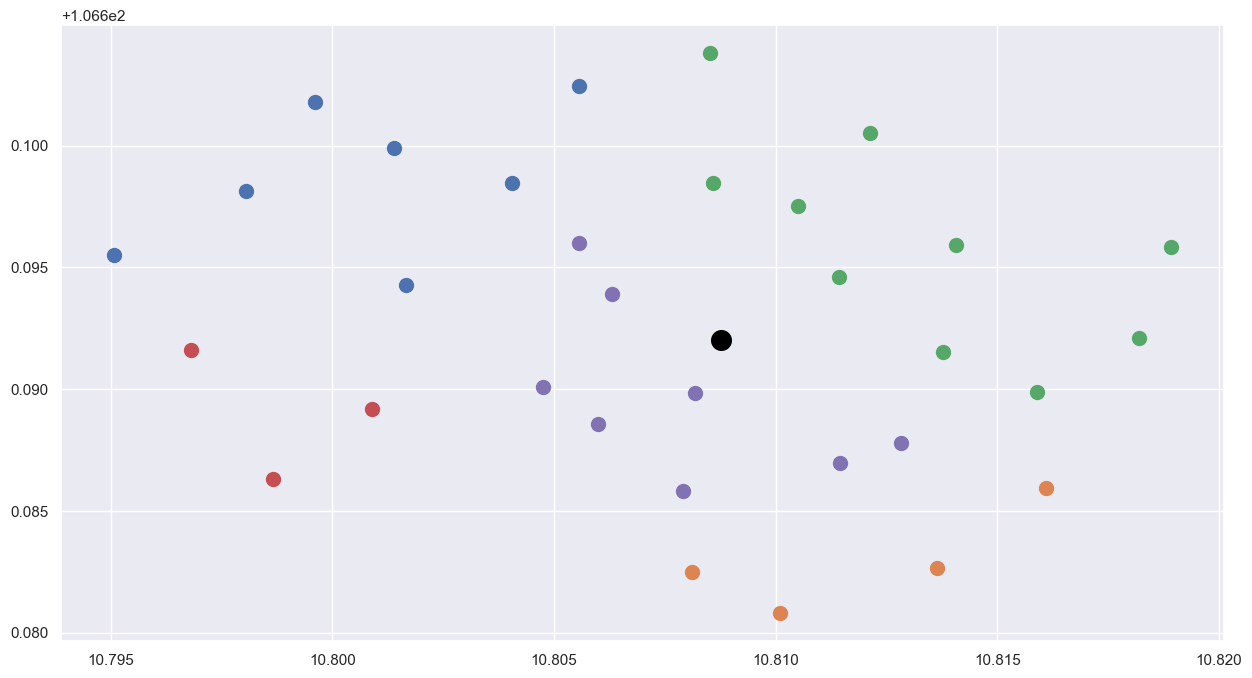

In [35]:
fig = plt.figure(figsize=(15, 8))
for i in range(len(clus_test_sample_kmean_1)):
    plt.scatter(clus_test_sample_kmean_1[i][:, 0], clus_test_sample_kmean_1[i][:, 1], cmap='viridis', s=100)
plt.scatter(data_depot_test_sample_1[:, 0], data_depot_test_sample_1[:, 1], s=200, c="black")
plt.show()

====================== cluster 0 ================
route for vehicle 0:
 7 -> 4 -> 3 -> 2 -> 1 -> 0 -> 6 -> 5 -> 7
 Distance of the route: 36km

Maximum of the route distances: 36
====================== cluster 1 ================
route for vehicle 0:
 4 -> 3 -> 2 -> 1 -> 0 -> 4
 Distance of the route: 27km

Maximum of the route distances: 27
====================== cluster 2 ================
route for vehicle 0:
 10 -> 8 -> 9 -> 6 -> 7 -> 1 -> 2 -> 3 -> 4 -> 5 -> 0 -> 10
 Distance of the route: 38km

Maximum of the route distances: 38
====================== cluster 3 ================
route for vehicle 0:
 3 -> 2 -> 1 -> 0 -> 3
 Distance of the route: 27km

Maximum of the route distances: 27
====================== cluster 4 ================
route for vehicle 0:
 8 -> 3 -> 7 -> 2 -> 1 -> 5 -> 6 -> 4 -> 0 -> 8
 Distance of the route: 25km

Maximum of the route distances: 25


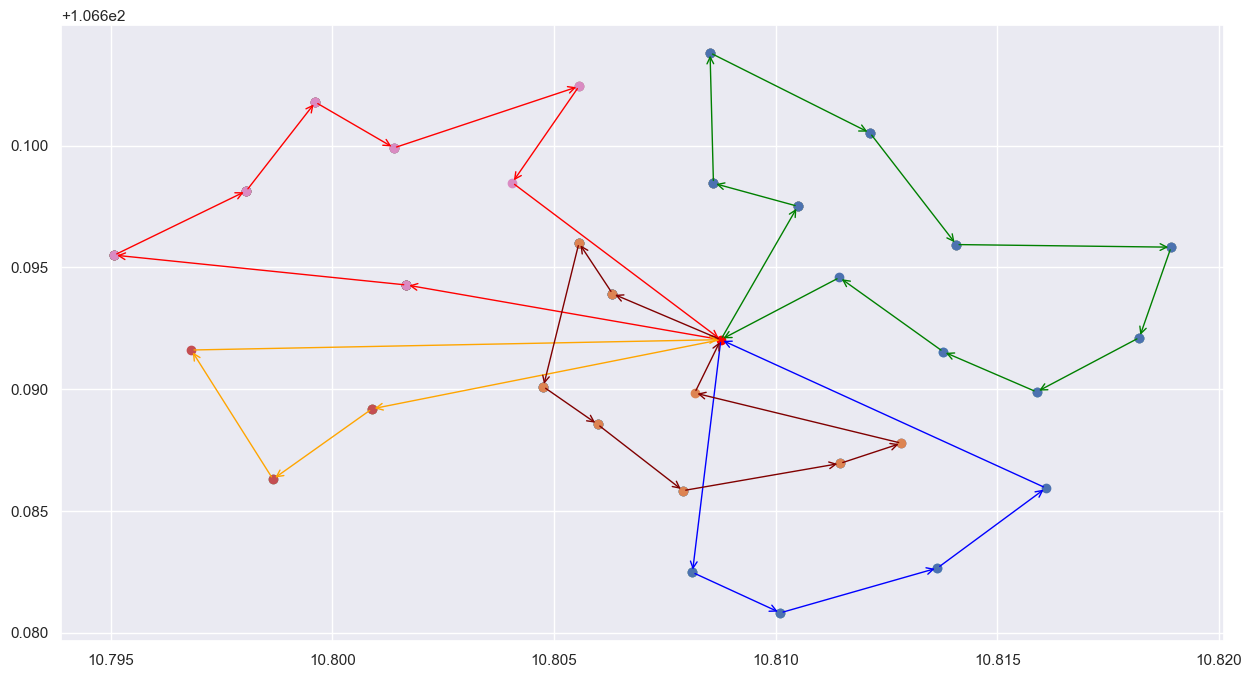

In [36]:
distance_sample_kmean_2 = show_result(data_test_sample_1, clus_test_sample_kmean_1, data_depot_test_sample_1)

In [37]:
print("Tổng khoảng cách đi được: {}".format(distance_sample_kmean_2))

Tổng khoảng cách đi được: 153


# IV. Thử nghiệm sample dataMau2
* tính toán sao cho các cụm dữ liệu phân bố đều với thuật toán kmeans

In [38]:
# Khởi tạo bộ dữ liệu.
list_point_sample = np.array([[10.808764, 106.692029], [10.808174, 106.689840], [10.805982, 106.688552], 
                              [10.804759, 106.690097], [10.806319, 106.693917], [10.811441, 106.694582], 
                              [10.814076, 106.695934], [10.818923, 106.695827], [10.818207, 106.692114], 
                              [10.815888, 106.689883], [10.813781, 106.691535], [10.812837, 106.687778], 
                              [10.816098, 106.685938], [10.813652, 106.682654], [10.810108, 106.680813], 
                              [10.808123, 106.682473], [10.807910, 106.685830], [10.811455, 106.686948], 
                              [10.801388, 106.699904], [10.799615, 106.701780], [10.798055, 106.698135], 
                              [10.795078, 106.695501], [10.796815, 106.691604], [10.798658, 106.686299], 
                              [10.800891, 106.689186], [10.801671, 106.694274], [10.805562, 106.696000], 
                              [10.804058, 106.698475], [10.805562, 106.702431], [10.808520, 106.703808], 
                              [10.812129, 106.700517], [10.810500, 106.697506], [10.808597, 106.698452]])
depot_sample = np.array([[10.8076046, 106.6958481]])

**Chú ý**

<p>xét cho n = 20 vòng lặp thuật toán kmean để tìm ra lần kmean phân bố đều nhất bằng cách sử dụngm độ lệch chuẩn để tính cho mỗi cụm.
trong 20 vòng lặp lấy vòng có độ lệch chuẩn thấp nhất đồng ghĩa với vòng có cụm phân bổ đều nhất</p>

In [39]:
# hàm tính độ lệch chuẩn
def stdev(list_point_clus):
    num_list = [len(lst_point) for lst_point in list_point_clus]
    stdve = 0
    avg = np.mean(num_list)
    for num in num_list:
        a = (num -avg)**2
        stdve += a
    std = stdve/len(num_list)
    return std

In [40]:
# hàm lặp duyệt các vòng thuật toán kmeans
def kmeans_clustering_equa_group(num, list_point_sample, num_cluster):
    """
        input: 
            num: số vòng lặp thuật toán kmeans
            list_point_sample: Danh sách chứa các điểm dữ liệu khách hàng
            num_cluster: Số cụm sẽ phân
        output: Đưa ra danh sách cụm phân bổ đều nhất.
            
    """
    std = []
    lst_nul = []
    cls_test_sample = clustering(list_point_sample, num_cluster)
    for i in range(num): 
        list_point_clus = cls_test_sample.Cluster_type("kmeans")
        lst_nul.append(list_point_clus)
        std.append(stdev(list_point_clus))



    val_std_min = std.index(min(std))
    return lst_nul[val_std_min]

In [46]:
datas = kmeans_clustering_equa_group(40, list_point_sample, 5)

====================== cluster 0 ================
route for vehicle 0:
 7 -> 0 -> 1 -> 2 -> 3 -> 6 -> 4 -> 5 -> 7
 Distance of the route: 31km

Maximum of the route distances: 31
====================== cluster 1 ================
route for vehicle 0:
 5 -> 0 -> 1 -> 2 -> 3 -> 4 -> 5
 Distance of the route: 30km

Maximum of the route distances: 30
====================== cluster 2 ================
route for vehicle 0:
 9 -> 0 -> 1 -> 2 -> 7 -> 6 -> 5 -> 4 -> 8 -> 3 -> 9
 Distance of the route: 32km

Maximum of the route distances: 32
====================== cluster 3 ================
route for vehicle 0:
 6 -> 5 -> 4 -> 3 -> 2 -> 1 -> 0 -> 6
 Distance of the route: 22km

Maximum of the route distances: 22
====================== cluster 4 ================
route for vehicle 0:
 6 -> 5 -> 4 -> 2 -> 3 -> 0 -> 1 -> 6
 Distance of the route: 26km

Maximum of the route distances: 26


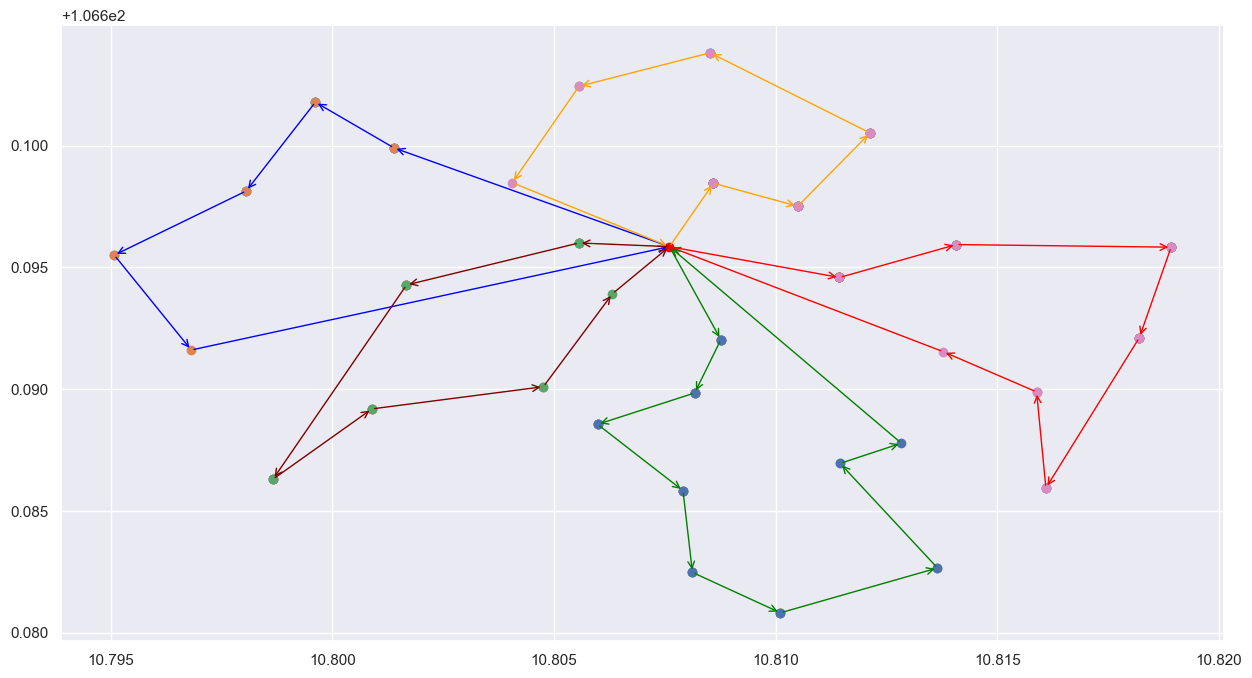

Thời gian thực thi 7.698884963989258 s


In [56]:
start_time = time.time()
distance_sample2 = show_result(list_point_sample, datas, depot_sample)
end_time = time.time()
executime = end_time - start_time
print("Thời gian thực thi {} s".format(executime))

In [57]:
print("tổng khoảng cách đi được: {}".format(distance_sample2))

tổng khoảng cách đi được: 141


<p> Code dưới thử trường hợp ngẫu nhiêu và không sử dụng phân bố đều cho các cụm</p>

====================== cluster 0 ================
route for vehicle 0:
 11 -> 10 -> 7 -> 8 -> 9 -> 2 -> 3 -> 4 -> 5 -> 6 -> 1 -> 0 -> 11
 Distance of the route: 38km

Maximum of the route distances: 38
====================== cluster 1 ================
route for vehicle 0:
 4 -> 3 -> 2 -> 1 -> 0 -> 4
 Distance of the route: 30km

Maximum of the route distances: 30
====================== cluster 2 ================
route for vehicle 0:
 2 -> 1 -> 0 -> 2
 Distance of the route: 25km

Maximum of the route distances: 25
====================== cluster 3 ================
route for vehicle 0:
 7 -> 6 -> 0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 7
 Distance of the route: 35km

Maximum of the route distances: 35
====================== cluster 4 ================
route for vehicle 0:
 9 -> 3 -> 0 -> 1 -> 2 -> 5 -> 4 -> 8 -> 7 -> 6 -> 9
 Distance of the route: 31km

Maximum of the route distances: 31


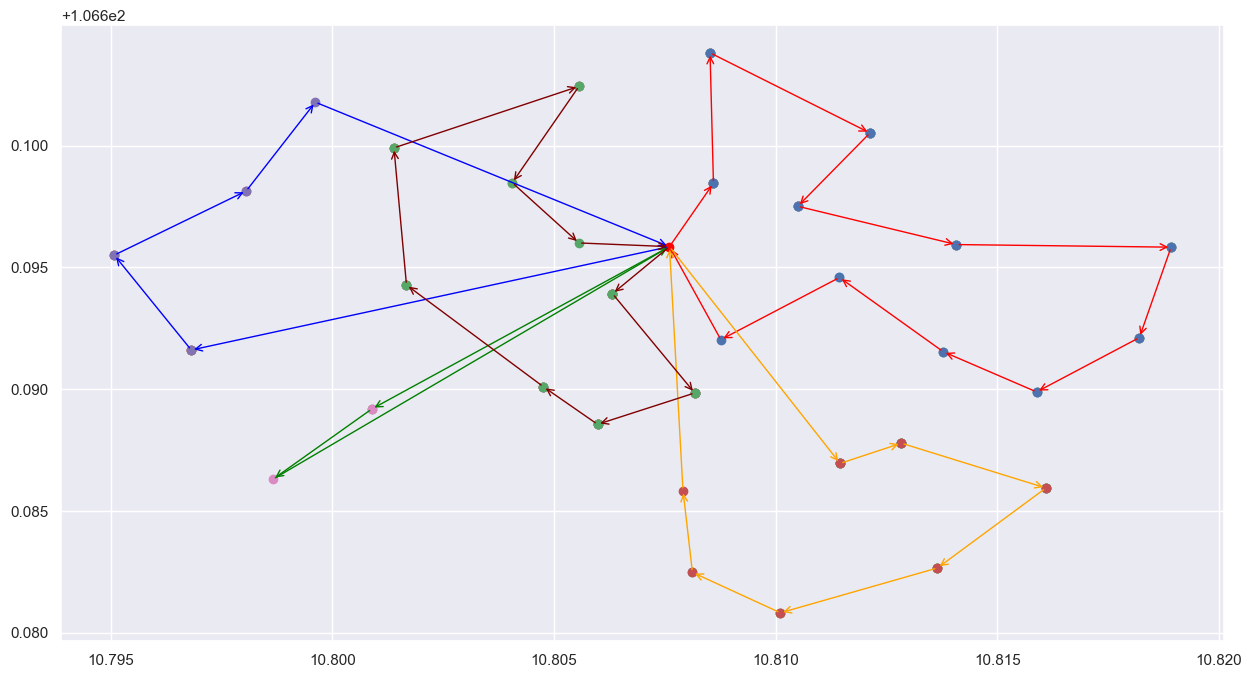

executime 36.551300287246704 s


In [58]:
clss = clustering(list_point_sample, 5)
data_2 = clss.Cluster_type("kmeans")
start_time = time.time()
distance_smaple_test_2 = show_result(list_point_sample, data_2, depot_sample)
end_time = time.time()
executime = end_time - start_time
print("executime {} s".format(executime))

In [59]:
print("Tổng khoảng cách đi được: {}".format(distance_smaple_test_2))

Tổng khoảng cách đi được: 159
